# GRU implementation from Scratch

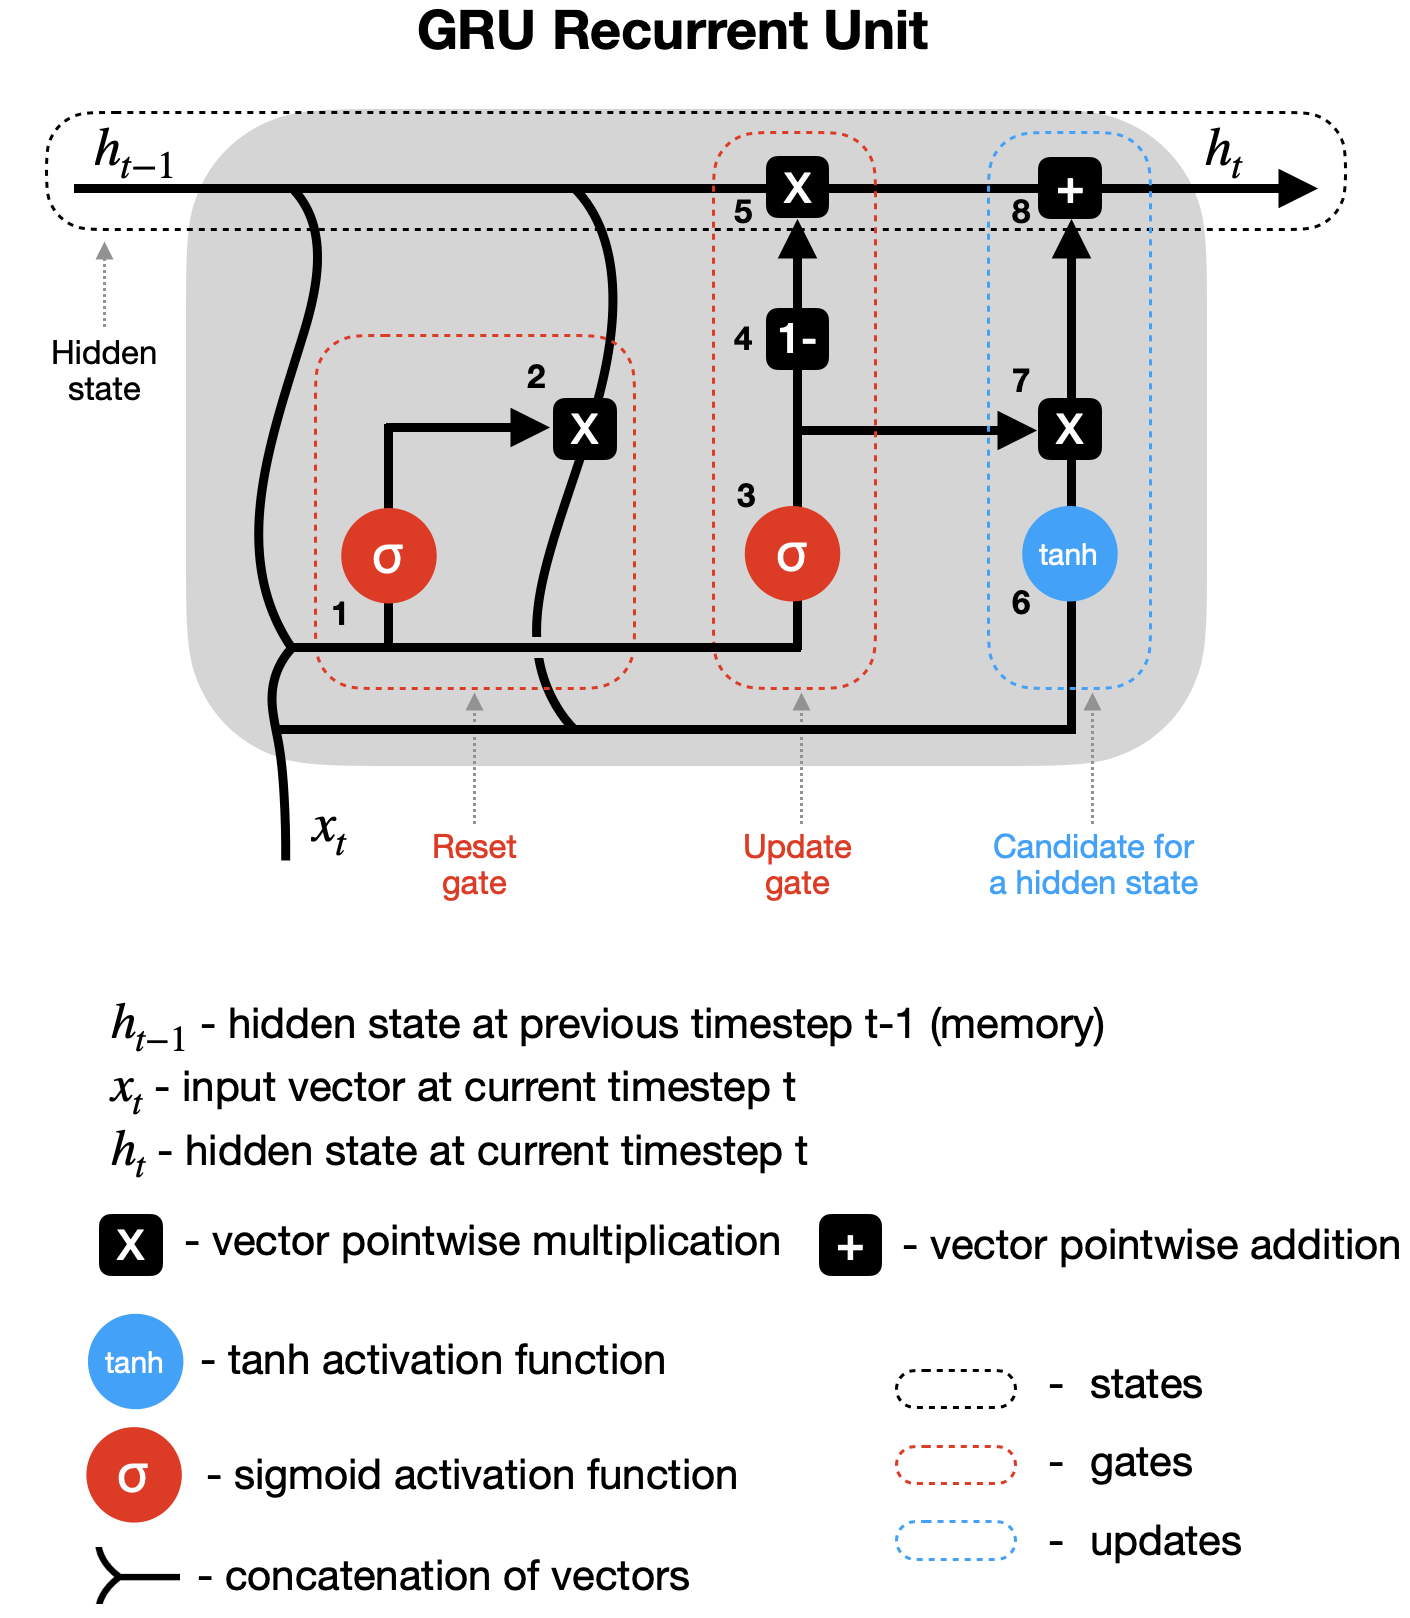

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class GRUcell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUcell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # weights for reset gate
        self.W_r = nn.Parameter(torch.randn(self.input_size+self.hidden_size, self.hidden_size))
        self.b_r = nn.Parameter(torch.zeros(self.hidden_size))

        # weights for update gate
        self.W_u = nn.Parameter(torch.randn(self.input_size+self.hidden_size, self.hidden_size))
        self.b_u = nn.Parameter(torch.zeros(self.hidden_size))

        # weights for candidate state
        self.W_c = nn.Parameter(torch.randn(self.input_size+self.hidden_size, self.hidden_size))
        self.b_c = nn.Parameter(torch.zeros(self.hidden_size))

    def forward(self, x, h_prev): #x -> batchsize, input_size
        # reset gate
        x_h = torch.cat((x, h_prev), axis=1) #batchsize X input_size+hidden_size
        r_sigmoid_out = torch.sigmoid( x_h @ self.W_r + self.b_r)
        reset_gate_out = h_prev * r_sigmoid_out

        # update gate
        u_sigmoid_out = torch.sigmoid( x_h @ self.W_u + self.b_u)
        h_prev = h_prev * 1 - u_sigmoid_out

        # candidate for hidden state
        x_h = torch.cat((x, reset_gate_out), axis=1)
        tanh_out = torch.tanh(x_h @ self.W_c + self.b_c)
        h_prev = h_prev + u_sigmoid_out * tanh_out
        return h_prev

In [10]:
batch_size = 2
input_size = 6
hidden_size = 2

x = torch.randn((batch_size, input_size))
h_prev = torch.randn((batch_size, hidden_size))

lstm_cell = GRUcell(input_size, hidden_size)
h_state = lstm_cell(x, h_prev)

print("h_state shape: ", h_state.shape)

h_state shape:  torch.Size([2, 2])


In [11]:
print("h_prev: ", h_prev)
print("h_state: ", h_state)

h_prev:  tensor([[-0.3251,  0.2516],
        [ 0.0294, -0.9288]])
h_state:  tensor([[-1.0593, -0.3222],
        [-0.0899, -1.0101]], grad_fn=<AddBackward0>)


# SimpleGRU

In [12]:
class SimpleGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleGRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.gru_cell = GRUcell(self.input_size, self.hidden_size)

    def forward(self, input_seq):
        # input_seq -> batch_size X sequence_length X input_size
        self.batch_size = input_seq.size(0)
        self.seq_length = input_seq.size(1)

        h_prev = torch.zeros(self.batch_size, self.hidden_size)
        outputs = []
        for seq_idx in range(self.seq_length):
            x = input_seq[:, seq_idx, :]
            h_prev = self.gru_cell(x, h_prev)
            outputs.append(h_prev.unsqueeze(1)) # batch_size X 1 X hidden_size

        return torch.cat(outputs, axis=1), h_prev

In [13]:
batch_size = 2
seq_len = 2
input_size = 6

x = torch.randn((batch_size, seq_len, input_size))

gru = SimpleGRU(input_size, hidden_size)
whole_seq_output, final_hidden_state = gru(x)

In [14]:
print("whole seq_output size", whole_seq_output.shape)
print("whole seq_output", whole_seq_output)

whole seq_output size torch.Size([2, 2, 2])
whole seq_output tensor([[[-0.2838, -1.8002],
         [-0.6315, -1.8233]],

        [[-1.7300, -0.5440],
         [-2.0100, -0.6222]]], grad_fn=<CatBackward0>)


In [15]:
print("final hidden state: ", final_hidden_state.shape)

final hidden state:  torch.Size([2, 2])
